In [10]:
# reading in the data:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/creditcard_sample.csv")
df.head()

train, test = train_test_split(df, test_size=0.2, random_state=11922105)

x_rows = ["Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount"]
y_row = "Class"

train_x = train[x_rows]
train_y = train[y_row]

test_x = test[x_rows]
test_y = test[y_row]

In [11]:
# how many cases?
len(df)
# how many fraud cases?
len(df[df["Class"] == 1])

223

In [12]:

from sklearn.utils import shuffle

def under_sample_majority(train, random_state=11922105):
    n = min(len(train[train["Class"] == 1]), len(train[train["Class"] == 0]))
    c1 = train[train["Class"] == 1].sample(n=n, random_state=random_state)
    c2 = train[train["Class"] == 0].sample(n=n, random_state=random_state)
    res = shuffle(pd.concat([c1,c2]), random_state=random_state)
    return res

train_undersampled = under_sample_majority(train)

train_u_x = train_undersampled[x_rows]
train_u_y = train_undersampled[y_row]


# Classical classification methods

- Logistic regression (LR)
- support vector machine (SVM)
- random forest (RF)


In [13]:
# logistic regression
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter = 4000)
reg.fit(train_x, train_y)
test_y_pred_log_reg = reg.predict(test_x) 

In [14]:
# support vector machine
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(train_x, train_y)
test_y_pred_svm = svm.predict(test_x) 


In [15]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(train_x, train_y)
test_y_pred_rfc = rfc.predict(test_x) 


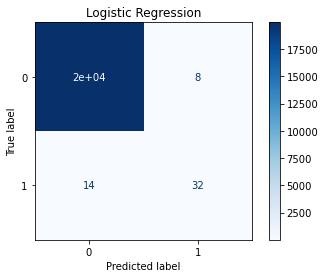

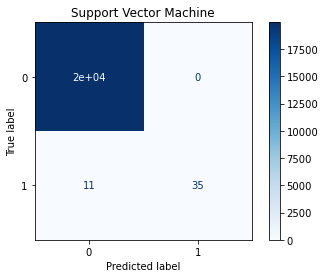

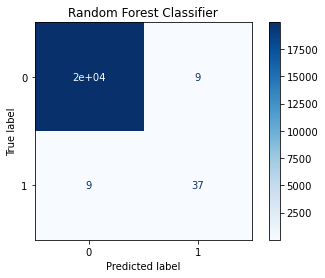

In [27]:
from sklearn.metrics import confusion_matrix as confusion_matrix_bad_impl, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import os
if not os.path.exists("latex/images/"):
    os.makedirs("latex/images/")

def confusion_matrix(y_true, y_pred):
    # is bad because does not always give 2x2 array as output
    c = confusion_matrix_bad_impl(y_true, y_pred)
    if(len(c) == 1):
        val = c[0][0]
        a = np.array([[0,0],[0,0]])
        if y_true[0]:
            a[1,1] = val
            return a
        else:
            a[0,0] = val
            return a
    return np.array(c)

def plot_confusion_matrix(true,predicted, title="", path=""):
    plot_confusion_matrix_from_matrix(confusion_matrix(true, predicted), title=title, path=path)

def plot_confusion_matrix_from_matrix(confusion_matrix, title="", path=""):
    d = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    fig, ax = plt.subplots()
    d.plot(cmap="Blues", ax=ax)
    ax.set_title(title)
    if(path != ""):
        fig.savefig(path, format='png', dpi=300, bbox_inches='tight')
    plt.show()

plot_confusion_matrix(test_y, reg.predict(test_x), title="Logistic Regression", path="latex/images/reg_conf1.png")

plot_confusion_matrix(test_y, svm.predict(test_x), title="Support Vector Machine", path="latex/images/svm_conf1.png")

plot_confusion_matrix(test_y, rfc.predict(test_x), title="Random Forest Classifier", path="latex/images/rfc_conf1.png")

In [31]:
def acc_prec_rec_f1(true_labels, predicted_labels):
    c = confusion_matrix(true_labels, predicted_labels)
    tn = c[0,0]
    tp = c[1,1]
    fp = c[0,1]
    fn = c[1,0]
    acc = (tp+tn)/(tn + tp + fp + fn)
    prec = tp/(tp+fp)
    rec = tp / (fn + tp)
    f1 = 2 * prec * rec /(prec + rec)
    return [round(e,9) for e in [acc, prec,rec, f1]]

tmpl = "{}: \nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}\n"

print(tmpl.format("Logistic Regression", *acc_prec_rec_f1(test_y, test_y_pred_log_reg)))
print(tmpl.format("Support Vector Machine", *acc_prec_rec_f1(test_y, test_y_pred_svm)))
print(tmpl.format("Random Forest Classifier", *acc_prec_rec_f1(test_y, test_y_pred_rfc)))


Logistic Regression: 
Accuracy: 0.9989
Precision: 0.8
Recall: 0.695652174
F1: 0.744186047

Support Vector Machine: 
Accuracy: 0.99945
Precision: 1.0
Recall: 0.760869565
F1: 0.864197531

Random Forest Classifier: 
Accuracy: 0.9991
Precision: 0.804347826
Recall: 0.804347826
F1: 0.804347826



In [32]:
# DNN definition
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam


def create_binary_classification_model(input_layer_size = 30, hidden_layers = 2, hidden_layer_size = 10) -> nn.Sequential:
    layers = [
        ("hidden_layer_1", nn.Linear(input_layer_size, hidden_layer_size)),
        ("activation_1", nn.ReLU())        
    ]
   
    for i in range(2, hidden_layers+1):
        layers.append((f"hidden_layer_{i}",nn.Linear(hidden_layer_size, hidden_layer_size) ))
        layers.append((f"activation_{i}",  nn.ReLU()))

    layers.append(("output_layer", nn.Linear(hidden_layer_size, 1)) )
    layers.append(("softmax", nn.Sigmoid()))
    return nn.Sequential(OrderedDict(layers))

def batch_iterator(xes, y, batch_size):
    for i in range(0, xes.shape[0], batch_size):
        yield (xes[i:i + batch_size], y[i:i + batch_size])


In [33]:
# create training and test data for torch
torch_train_x = torch.from_numpy(train_x.to_numpy()).float()
torch_train_u_x = torch.from_numpy(train_u_x.to_numpy()).float()
torch_test_x = torch.from_numpy(test_x.to_numpy()).float()
torch_train_y = torch.from_numpy(train_y.to_numpy()).unsqueeze(1).float()
torch_train_u_y = torch.from_numpy(train_u_y.to_numpy()).unsqueeze(1).float()
torch_test_y = torch.from_numpy(test_y.to_numpy()).unsqueeze(1).float()

print(torch_train_x.size())
print(torch_train_y.size())
print(torch_train_u_x.size())
print(torch_train_u_y.size())
print(torch_test_x.size())
print(torch_test_y.size())

torch.Size([79999, 30])
torch.Size([79999, 1])
torch.Size([354, 30])
torch.Size([354, 1])
torch.Size([20000, 30])
torch.Size([20000, 1])


In [75]:
import typing
import sklearn

from torchmetrics import Accuracy
from sklearn import metrics


def confusion_matrix_to_accuracy(confusion):
    return (confusion[0,0] + confusion[1,1]) / confusion_matrix_to_sample_count(confusion)

def confusion_matrix_to_sample_count(confusion):
    return confusion[0,0] +  confusion[0,1] +  confusion[1,0] +  confusion[1,1]

accuracy = Accuracy()

def determine_device():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    return DEVICE

class TrainSettings:
    EPOCHS = 4
    BATCH_SIZE = 64
    LR = 0.001
    LOSS_FUNCTION = nn.BCELoss()
    DEVICE = determine_device()

    def __init__(self, EPOCHS = 4, BATCH_SIZE = 64, LR = 0.001, LOSS_FUNCTION=nn.BCELoss(), ) -> None:
        self.DEVICE = determine_device()
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.LR = LR
        self.LOSS_FUNCTION = LOSS_FUNCTION

class EpochStats:
    train_loss: float
    test_loss: float
    epoch: int
    def __init__(self,epoch, train_loss, train_conf, test_loss, test_conf) -> None:
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.train_confusion = train_conf
        self.test_confusion = test_conf

class TrainStats:
    train_settings: TrainSettings
    epochs: typing.List[EpochStats]
    
    # def add_epoch(train_loss)
    def __init__(self, train_settings, name) -> None:
        self.train_settings = train_settings
        self.epochs = []
        self.name = name

    def identifier(self) -> str:
        return f"{self.name}_E{self.train_settings.EPOCHS}_LR{self.train_settings.LR}_B{self.train_settings.BATCH_SIZE}"

    def calc_roc_and_prc_curves(self, y_true, y_pred):
        self.roc_fpr, self.roc_tpr, _ = metrics.roc_curve(y_true,  y_pred)
        self.prc_prec, self.prc_rec, _ = metrics.precision_recall_curve(y_true,  y_pred)

    def _savepath(self):
        return f"latex/images/{self.identifier()}/"
    
    def save_report(self, net=None):
        dirname = self._savepath()
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        if net is not None:
            torch.save(net.state_dict(), f"{dirname}model.pt")
        self.visualize_roc_and_prc_curves(save=True)
        self.visualize_loss(save=True)
        self.visualize_accuracy(save=True)
        self.plot_confusion_matrizes(save=True)
        

    def add_epoch(self, epoch_stats: EpochStats):
        self.epochs.append(epoch_stats)

    def visualize_loss(self, save=False):
        x = [e.epoch for e in self.epochs]
        fig, ax = plt.subplots()
        ax.plot(x, [e.train_loss for e in self.epochs], label = "Train Loss")
        ax.plot(x, [e.test_loss for e in self.epochs], label = "Test Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        if save:
            fig.savefig(f"{self._savepath()}loss.png", format='png', dpi=300, bbox_inches='tight')
        plt.show()  

    def visualize_accuracy(self, save=False):
        x = [e.epoch for e in self.epochs]
        fig, ax = plt.subplots()
        ax.plot(x, [confusion_matrix_to_accuracy(e.test_confusion) for e in self.epochs], label = "Train Accuracy")
        ax.plot(x, [confusion_matrix_to_accuracy(e.train_confusion) for e in self.epochs], label = "Test Accuracy")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        if save:
            fig.savefig(f"{self._savepath()}accuracy.png", format='png', dpi=300, bbox_inches='tight')
    
    def visualize_roc_and_prc_curves(self, save=False):
        fig, ax = plt.subplots()
        ax.plot(self.roc_fpr,self.roc_tpr)
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        if save:
            fig.savefig(f"{self._savepath()}roc.png", format='png', dpi=300, bbox_inches='tight')
        plt.show()  
        fig, ax = plt.subplots()
        ax.plot(self.prc_rec,self.prc_prec)
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
        if save:
            fig.savefig(f"{self._savepath()}prc.png", format='png', dpi=300, bbox_inches='tight')
        plt.show() 

    def plot_confusion_matrizes(self, save=False):
        path_test = f"{self._savepath()}conf_test.png"
        path_train = f"{self._savepath()}conf_train.png"
        plot_confusion_matrix_from_matrix(self.epochs[len(self.epochs)-1].train_confusion, "Train Confusion Matrix", path=path_train if save else "")
        plot_confusion_matrix_from_matrix(self.epochs[len(self.epochs)-1].test_confusion, "Test Confusion Matrix", path=path_test if save else "")



In [76]:
# training function to turn a model into a trained network
from typing import Tuple

def train_network_from_model(model, train_x, train_y, test_x, test_y, train_settings: TrainSettings = TrainSettings(), name="") ->  Tuple[nn.Sequential,TrainStats] :
    print(f"using {train_settings.DEVICE} for training, EPOCHS={train_settings.EPOCHS}, BATCH_SIZE={train_settings.BATCH_SIZE}, LR={train_settings.LR}")
    
    network = model.to(train_settings.DEVICE)
    optimizer = Adam(network.parameters(), lr=train_settings.LR)
    train_stats = TrainStats(train_settings, name=f"{name}")
    for epoch in range(1, train_settings.EPOCHS+1):
        print(f"EPOCH {epoch}:")
        train_loss, train_conf = train_network(network, optimizer, train_x, train_y, train_settings)
        test_loss, test_conf = evaluate_network(network, test_x, test_y, train_settings, train_stats_to_calculate_curves_for = train_stats if epoch == train_settings.EPOCHS else None)
        train_stats.add_epoch(EpochStats(epoch, train_loss, train_conf, test_loss, test_conf))
    return (network, train_stats)

def train_network(network, optimizer, train_x, train_y, train_settings: TrainSettings):
    loss, conf = 0, [[0,0],[0,0]]
    network.train()
    for (bx,by) in batch_iterator(train_x, train_y, train_settings.BATCH_SIZE):
        l, c = train_network_on_batch(network, optimizer, bx,by, train_settings)
        loss += l * confusion_matrix_to_sample_count(c)
        conf += c
    loss = loss / confusion_matrix_to_sample_count(conf)
    acc = confusion_matrix_to_accuracy(conf)
    print("TRAIN: train loss: {:.5f} train accuracy: {:.5f}".format(loss,
            acc))
    return loss, conf

def train_network_on_batch(network, optimizer, bx,by,train_settings: TrainSettings):
    pred = network(bx)
    loss = train_settings.LOSS_FUNCTION(pred, by.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    conf = confusion_matrix(by == 1, pred > 0.5)
    return loss, conf

def evaluate_network(network, test_x, test_y, train_settings, train_stats_to_calculate_curves_for=None):
    network.eval() # activate eval mode
    # initialize a no-gradient context
    with torch.no_grad():
        # loop over the current batch of test data
        (test_x_1, test_y_1) = (test_x.to(train_settings.DEVICE), test_y.to(train_settings.DEVICE))
        predictions = network(test_x_1).float()   
        loss = train_settings.LOSS_FUNCTION(predictions, test_y_1.float())
        conf = confusion_matrix(test_y_1 == 1, predictions > 0.5)
        acc = confusion_matrix_to_accuracy(conf)
        if(train_stats_to_calculate_curves_for is not None):
            train_stats_to_calculate_curves_for.calc_roc_and_prc_curves(test_y_1 == 1, predictions > 0.5)
        print("EVAL: test loss: {:.5f} test accuracy: {:.5f}".format(loss, acc))
        return loss, conf 

using cpu for training, EPOCHS=3, BATCH_SIZE=128, LR=3e-05
EPOCH 1:
TRAIN: train loss: 0.06025 train accuracy: 0.99495
EVAL: test loss: 0.04815 test accuracy: 0.99665
EPOCH 2:
TRAIN: train loss: 0.04922 train accuracy: 0.99722
EVAL: test loss: 0.04677 test accuracy: 0.99755
EPOCH 3:
TRAIN: train loss: 0.04823 train accuracy: 0.99769
EVAL: test loss: 0.04581 test accuracy: 0.99765


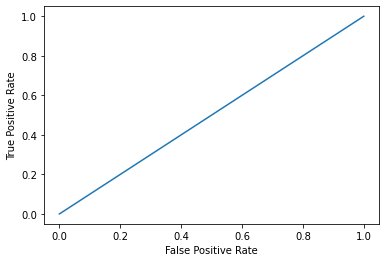

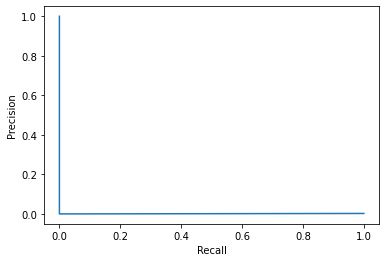

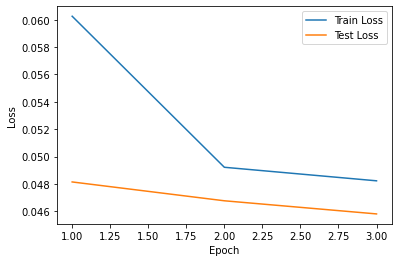

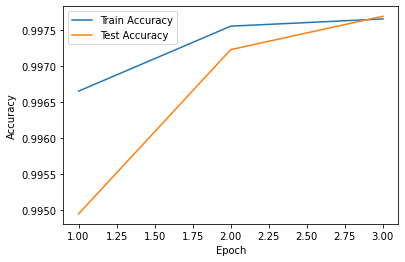

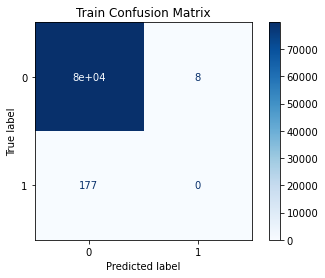

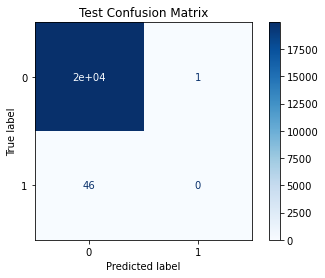

In [77]:
# how to create and train a model now (example)
model = create_binary_classification_model(30, 4, 8)
train_settings = TrainSettings(EPOCHS=3, LR=0.00003, BATCH_SIZE=128)
net, stats = train_network_from_model(model, torch_train_x, torch_train_y, torch_test_x, torch_test_y, train_settings, name="net(d4xk8)")
stats.save_report(net=net)

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.001
EPOCH 1:
TRAIN: train loss: 0.19014 train accuracy: 0.99726
EVAL: test loss: 0.23001 test accuracy: 0.99770
EPOCH 2:
TRAIN: train loss: 0.22045 train accuracy: 0.99779
EVAL: test loss: 0.23000 test accuracy: 0.99770
EPOCH 3:
TRAIN: train loss: 0.22074 train accuracy: 0.99779
EVAL: test loss: 0.23000 test accuracy: 0.99770
EPOCH 4:
TRAIN: train loss: 0.22096 train accuracy: 0.99779
EVAL: test loss: 0.23000 test accuracy: 0.99770
EPOCH 5:
TRAIN: train loss: 0.22125 train accuracy: 0.99779
EVAL: test loss: 0.23000 test accuracy: 0.99770
EPOCH 6:
TRAIN: train loss: 0.22125 train accuracy: 0.99779
EVAL: test loss: 0.23000 test accuracy: 0.99770
EPOCH 7:
TRAIN: train loss: 0.22125 train accuracy: 0.99779
EVAL: test loss: 0.23000 test accuracy: 0.99770
EPOCH 8:
TRAIN: train loss: 0.22125 train accuracy: 0.99779
EVAL: test loss: 0.23000 test accuracy: 0.99770
EPOCH 9:
TRAIN: train loss: 0.22125 train accuracy: 0.99779
EVAL: test loss: 

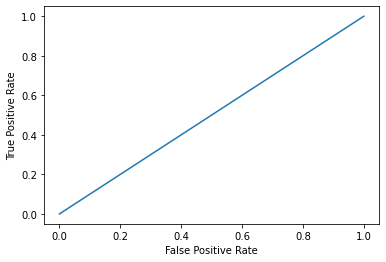

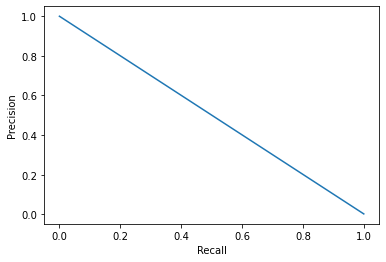

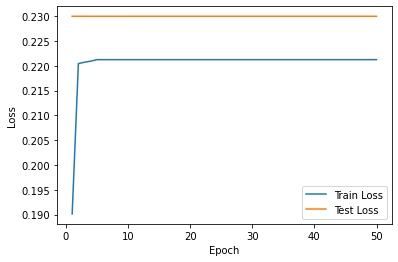

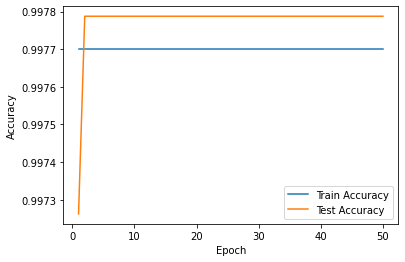

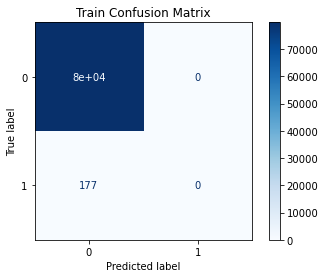

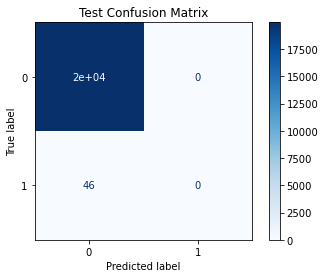

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=0.0001
EPOCH 1:
TRAIN: train loss: 2.12090 train accuracy: 0.91259
EVAL: test loss: 0.05834 test accuracy: 0.97620
EPOCH 2:
TRAIN: train loss: 0.05836 train accuracy: 0.98070
EVAL: test loss: 0.05439 test accuracy: 0.98400
EPOCH 3:
TRAIN: train loss: 0.05551 train accuracy: 0.98691
EVAL: test loss: 0.05186 test accuracy: 0.98840
EPOCH 4:
TRAIN: train loss: 0.05270 train accuracy: 0.99197
EVAL: test loss: 0.04892 test accuracy: 0.99485
EPOCH 5:
TRAIN: train loss: 0.04931 train accuracy: 0.99724
EVAL: test loss: 0.04463 test accuracy: 0.99770
EPOCH 6:
TRAIN: train loss: 0.04471 train accuracy: 0.99779
EVAL: test loss: 0.04096 test accuracy: 0.99770
EPOCH 7:
TRAIN: train loss: 0.04082 train accuracy: 0.99779
EVAL: test loss: 0.03566 test accuracy: 0.99770
EPOCH 8:
TRAIN: train loss: 0.03556 train accuracy: 0.99779
EVAL: test loss: 0.03062 test accuracy: 0.99770
EPOCH 9:
TRAIN: train loss: 0.03175 train accuracy: 0.99779
EVAL: test loss:

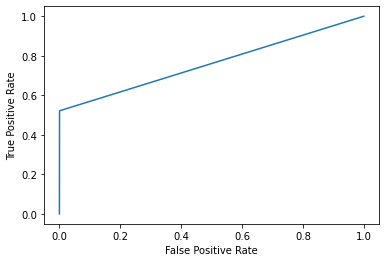

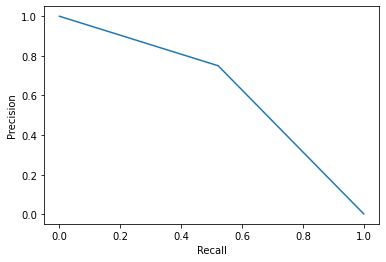

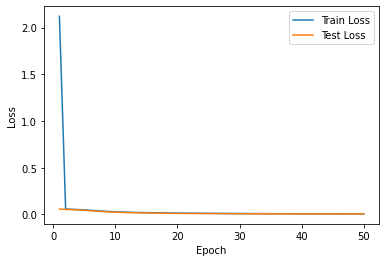

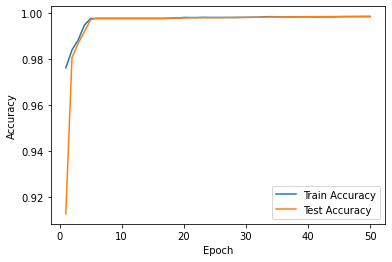

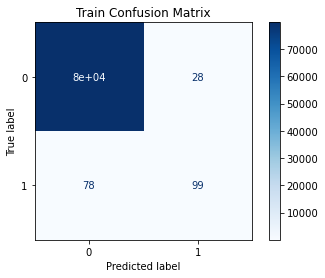

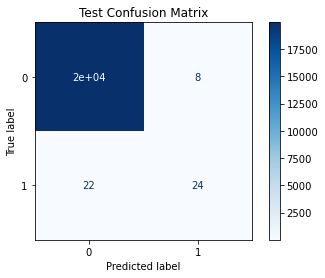

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=3e-05
EPOCH 1:
TRAIN: train loss: 0.23657 train accuracy: 0.99754
EVAL: test loss: 0.04643 test accuracy: 0.99770
EPOCH 2:
TRAIN: train loss: 0.04710 train accuracy: 0.99779
EVAL: test loss: 0.04424 test accuracy: 0.99770
EPOCH 3:
TRAIN: train loss: 0.04573 train accuracy: 0.99779
EVAL: test loss: 0.04284 test accuracy: 0.99770
EPOCH 4:
TRAIN: train loss: 0.04410 train accuracy: 0.99779
EVAL: test loss: 0.04083 test accuracy: 0.99770
EPOCH 5:
TRAIN: train loss: 0.04214 train accuracy: 0.99779
EVAL: test loss: 0.03913 test accuracy: 0.99770
EPOCH 6:
TRAIN: train loss: 0.04034 train accuracy: 0.99779
EVAL: test loss: 0.03733 test accuracy: 0.99770
EPOCH 7:
TRAIN: train loss: 0.03853 train accuracy: 0.99779
EVAL: test loss: 0.03554 test accuracy: 0.99770
EPOCH 8:
TRAIN: train loss: 0.03676 train accuracy: 0.99779
EVAL: test loss: 0.03379 test accuracy: 0.99770
EPOCH 9:
TRAIN: train loss: 0.03508 train accuracy: 0.99779
EVAL: test loss: 

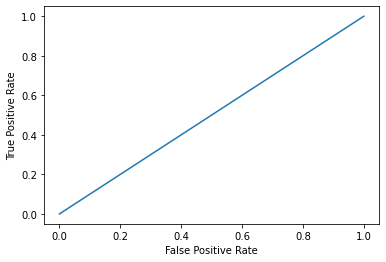

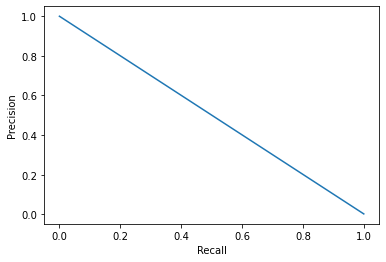

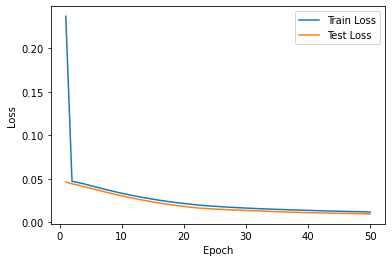

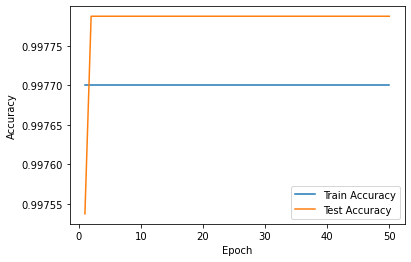

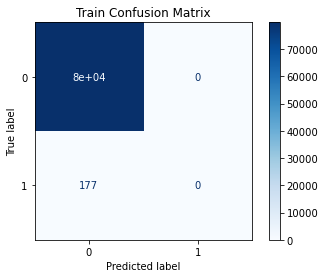

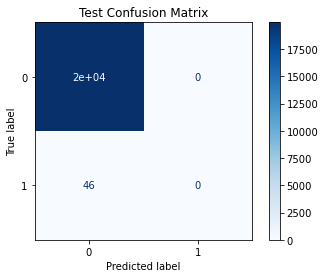

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=1e-05
EPOCH 1:
TRAIN: train loss: 96.58036 train accuracy: 0.00235
EVAL: test loss: 95.53200 test accuracy: 0.00240
EPOCH 2:
TRAIN: train loss: 94.56516 train accuracy: 0.00259
EVAL: test loss: 93.49211 test accuracy: 0.00295
EPOCH 3:
TRAIN: train loss: 69.81848 train accuracy: 0.01188
EVAL: test loss: 0.70104 test accuracy: 0.40810
EPOCH 4:
TRAIN: train loss: 0.15757 train accuracy: 0.99391
EVAL: test loss: 0.07682 test accuracy: 0.99600
EPOCH 5:
TRAIN: train loss: 0.06726 train accuracy: 0.99597
EVAL: test loss: 0.05751 test accuracy: 0.99620
EPOCH 6:
TRAIN: train loss: 0.05589 train accuracy: 0.99622
EVAL: test loss: 0.05054 test accuracy: 0.99630
EPOCH 7:
TRAIN: train loss: 0.05109 train accuracy: 0.99637
EVAL: test loss: 0.04697 test accuracy: 0.99650
EPOCH 8:
TRAIN: train loss: 0.04744 train accuracy: 0.99662
EVAL: test loss: 0.04488 test accuracy: 0.99685
EPOCH 9:
TRAIN: train loss: 0.04585 train accuracy: 0.99681
EVAL: test l

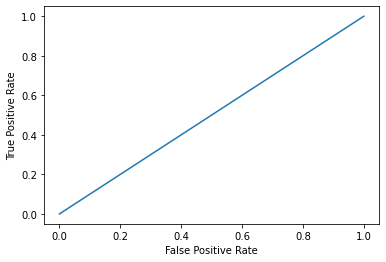

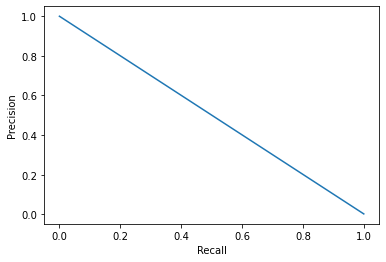

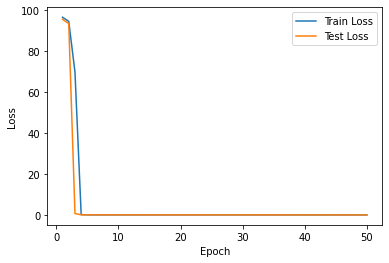

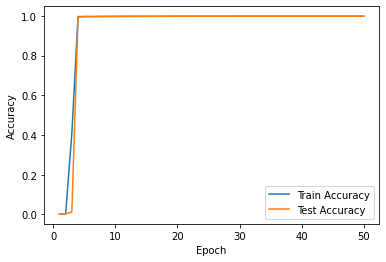

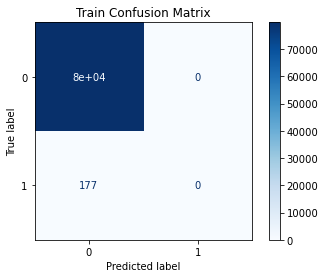

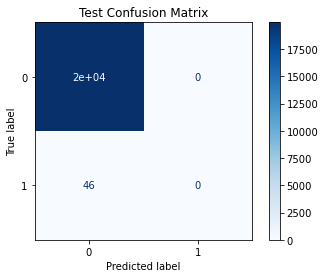

using cpu for training, EPOCHS=50, BATCH_SIZE=64, LR=3e-06
EPOCH 1:
TRAIN: train loss: 94.72769 train accuracy: 0.00484
EVAL: test loss: 94.28186 test accuracy: 0.00550
EPOCH 2:
TRAIN: train loss: 93.61960 train accuracy: 0.00528
EVAL: test loss: 93.16787 test accuracy: 0.00605
EPOCH 3:
TRAIN: train loss: 92.67817 train accuracy: 0.00570
EVAL: test loss: 91.99335 test accuracy: 0.00660
EPOCH 4:
TRAIN: train loss: 91.47003 train accuracy: 0.00650
EVAL: test loss: 91.15858 test accuracy: 0.00715
EPOCH 5:
TRAIN: train loss: 90.56071 train accuracy: 0.00729
EVAL: test loss: 90.13679 test accuracy: 0.00795
EPOCH 6:
TRAIN: train loss: 89.67014 train accuracy: 0.00829
EVAL: test loss: 88.82454 test accuracy: 0.00890
EPOCH 7:
TRAIN: train loss: 87.57582 train accuracy: 0.00990
EVAL: test loss: 85.91349 test accuracy: 0.01095
EPOCH 8:
TRAIN: train loss: 78.05871 train accuracy: 0.01269
EVAL: test loss: 61.88959 test accuracy: 0.01535
EPOCH 9:
TRAIN: train loss: 30.14442 train accuracy: 0.02071


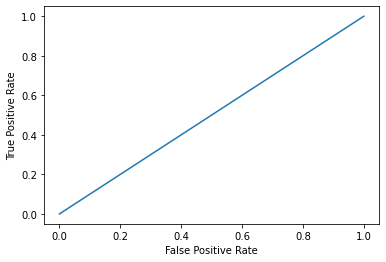

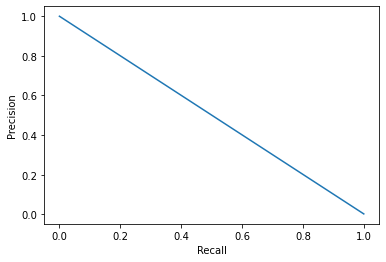

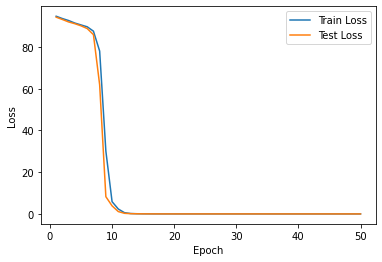

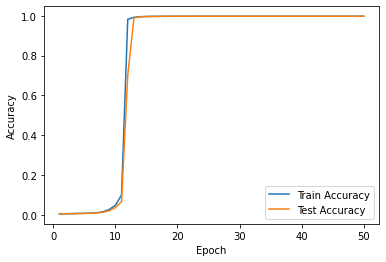

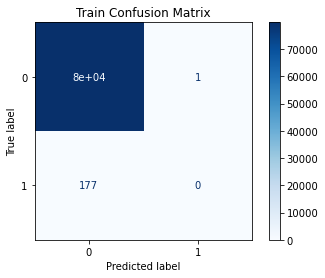

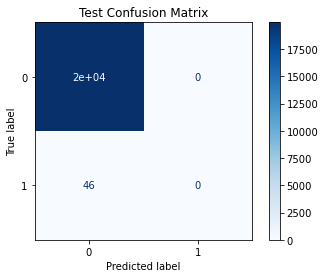

In [78]:
# Grid Search over Learning Rate, considering LR from [0.001, 0.0001, 0.00003, 0.00001, 0.000003]
for LR in [0.001, 0.0001, 0.00003,0.00001, 0.000003]:
    d = 4 # depth
    k = 8 # layer size
    model = create_binary_classification_model(30, d, k)
    train_settings = TrainSettings(EPOCHS=50, LR=LR, BATCH_SIZE=64)
    net, stats = train_network_from_model(model, torch_train_x, torch_train_y, torch_test_x, torch_test_y, train_settings, name=f"net(d{d}_k{8})")
    stats.save_report(net=net)

using cpu for training, EPOCHS=200, BATCH_SIZE=64, LR=3e-07
EPOCH 1:
TRAIN: train loss: 70.61842 train accuracy: 0.00886
EVAL: test loss: 67.93047 test accuracy: 0.00885
EPOCH 2:
TRAIN: train loss: 64.86207 train accuracy: 0.00898
EVAL: test loss: 61.37180 test accuracy: 0.00890
EPOCH 3:
TRAIN: train loss: 56.31194 train accuracy: 0.00911
EVAL: test loss: 51.34335 test accuracy: 0.00900
EPOCH 4:
TRAIN: train loss: 45.25300 train accuracy: 0.00934
EVAL: test loss: 38.78720 test accuracy: 0.00935
EPOCH 5:
TRAIN: train loss: 30.44489 train accuracy: 0.00970
EVAL: test loss: 21.55742 test accuracy: 0.00980
EPOCH 6:
TRAIN: train loss: 13.59491 train accuracy: 0.01034
EVAL: test loss: 10.31134 test accuracy: 0.01070
EPOCH 7:
TRAIN: train loss: 9.25400 train accuracy: 0.01120
EVAL: test loss: 8.30740 test accuracy: 0.01175
EPOCH 8:
TRAIN: train loss: 7.48435 train accuracy: 0.01236
EVAL: test loss: 6.66356 test accuracy: 0.01340
EPOCH 9:
TRAIN: train loss: 5.89944 train accuracy: 0.01406
EVAL

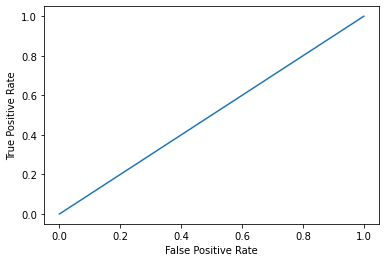

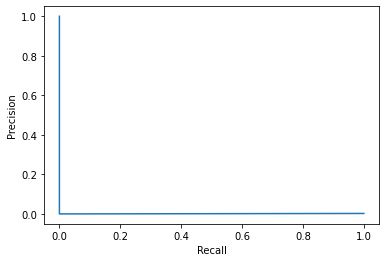

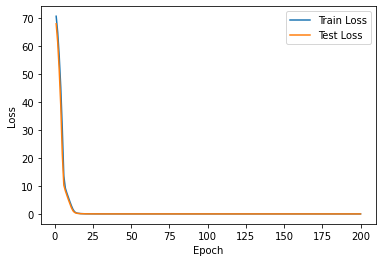

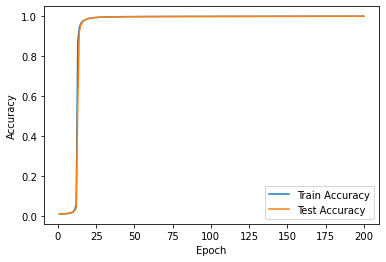

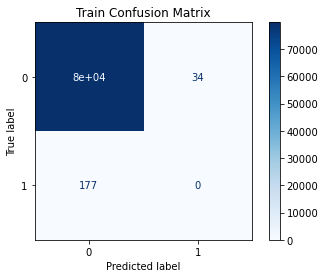

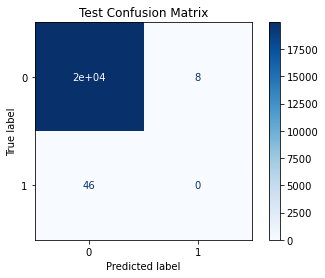

In [80]:
# Grid Search over a few more learning rates: [0.000001, 0.0000003, 0.0000001]
for LR in [0.0000003]:
    d = 4 # depth
    k = 8 # layer size
    model = create_binary_classification_model(30, d, k)
    train_settings = TrainSettings(EPOCHS=200, LR=LR, BATCH_SIZE=64)
    net, stats = train_network_from_model(model, torch_train_x, torch_train_y, torch_test_x, torch_test_y, train_settings, name=f"net(d{d}_k{8})")
    stats.save_report(net=net)

In [64]:
# example model with undersampling
model = create_binary_classification_model(30, 4, 8)
train_settings = TrainSettings(EPOCHS=3000, LR=0.00003, BATCH_SIZE=32)
net, stats = train_network_from_model(model, torch_train_u_x, torch_train_u_y, torch_test_x, torch_test_y, train_settings)

using cpu for training, EPOCHS=3000, BATCH_SIZE=32, LR=3e-05
EPOCH 1:
TRAIN: train loss: 45.00854 train accuracy: 0.50000
EVAL: test loss: 0.19850 test accuracy: 0.99770
EPOCH 2:
TRAIN: train loss: 44.93990 train accuracy: 0.50000
EVAL: test loss: 0.19829 test accuracy: 0.99770
EPOCH 3:
TRAIN: train loss: 44.90488 train accuracy: 0.50000
EVAL: test loss: 0.19808 test accuracy: 0.99770
EPOCH 4:
TRAIN: train loss: 44.83803 train accuracy: 0.50000
EVAL: test loss: 0.19789 test accuracy: 0.99770
EPOCH 5:
TRAIN: train loss: 44.80202 train accuracy: 0.50000
EVAL: test loss: 0.19768 test accuracy: 0.99770
EPOCH 6:
TRAIN: train loss: 44.76586 train accuracy: 0.50000
EVAL: test loss: 0.19691 test accuracy: 0.99770
EPOCH 7:
TRAIN: train loss: 44.73020 train accuracy: 0.50000
EVAL: test loss: 0.19610 test accuracy: 0.99770
EPOCH 8:
TRAIN: train loss: 44.69447 train accuracy: 0.50000
EVAL: test loss: 0.19584 test accuracy: 0.99770
EPOCH 9:
TRAIN: train loss: 44.65729 train accuracy: 0.50000
EVAL: 

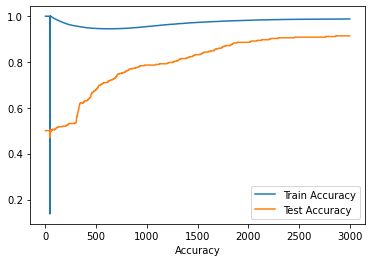

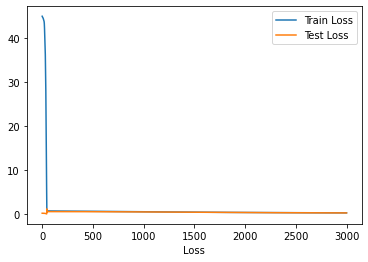

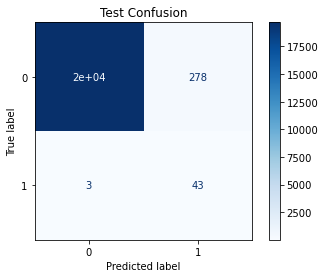

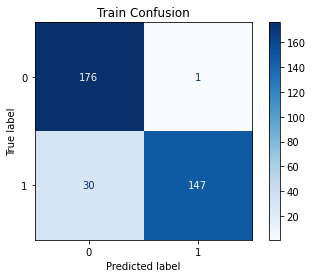

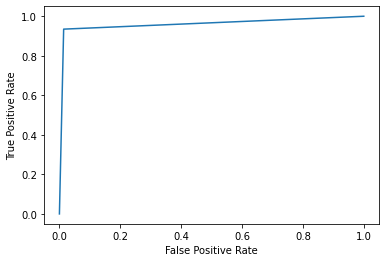

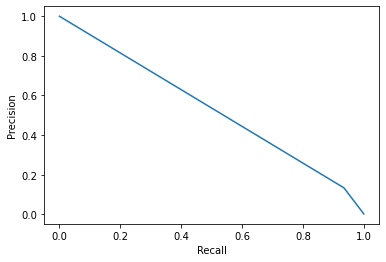

In [65]:
stats.visualize_accuracy()
stats.visualize_loss()
stats.plot_confusion_matrizes()
stats.visualize_roc_and_prc_curves()

In [411]:
confusion_matrix_to_accuracy(stats.epochs[stats.epochs.__len__() - 1].train_confusion)

0.9977874723434043